In [ ]:
import numpy as np
from scipy.stats import genpareto
from scipy.stats.mstats import scoreatpercentile
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [1]:
def gpdReturnLevel(intervals, mu, shape, scale, rate, npyr=365.25):
    T = np.asarray(intervals, dtype=float)
    lam_per_year = rate * npyr
    if np.isclose(shape, 0.0):
        return mu + scale * np.log(lam_per_year * T)
    return mu + (scale / shape) * ((lam_per_year * T)**shape - 1.0)

def gpdfit(data, intervals, numsim, missingValue=-9999, minrecords=50, threshold=99.5):
    data = np.asarray(data, dtype=float)
    data = data[data != missingValue]
    recs = data[data > 0]

    # threshold on valid positives
    mu = scoreatpercentile(recs, threshold)

    loc, scl, shp = [missingValue, missingValue, missingValue]
    Rp = missingValue * np.ones(len(intervals))

    # Fill zeros for days without cyclones
    N = int(numsim * 365.25)
    datafilled = np.zeros(N)
    datafilled[-len(recs):] = recs

    rate = float(np.sum(datafilled > mu)) / float(N)  # per day

    if len(recs) < minrecords:
        return Rp, loc, scl, shp, rate, mu, datafilled

    try:
        shape, location, scale = genpareto.fit(datafilled[datafilled > mu], floc=mu)
    except Exception:
        return Rp, loc, scl, shp, rate, mu, datafilled

    Rpeval = gpdReturnLevel(intervals, mu, shape, scale, rate)
    # You probably do not want to discard shape > 0; keep both signs
    return Rpeval, location, scale, shape, rate, mu, datafilled

def gpd_return_level_CI(datafilled, mu, shape, scale, rate, intervals, B=1000, ci=95):
    alpha = (100 - ci) / 2.0
    bootstrap_RL = np.zeros((B, len(intervals)))
    N = len(datafilled)

    for b in range(B):
        nexceed = np.random.poisson(rate * N)
        if nexceed <= 0:
            continue
        y = genpareto.rvs(c=shape, loc=mu, scale=scale, size=nexceed)

        sim_series = np.zeros(N)
        sim_series[-nexceed:] = y

        try:
            shp_b, loc_b, scl_b = genpareto.fit(sim_series[sim_series > mu], floc=mu)
        except Exception:
            continue

        rate_b = float(np.sum(sim_series > mu)) / float(N)
        bootstrap_RL[b, :] = gpdReturnLevel(intervals, mu, shp_b, scl_b, rate_b)

    bootstrap_RL = bootstrap_RL[np.any(bootstrap_RL != 0, axis=1)]
    lower = np.percentile(bootstrap_RL, alpha, axis=0)
    upper = np.percentile(bootstrap_RL, 100 - alpha, axis=0)
    return lower, upper

In [17]:
# ---------------------------
# (1) POT empirical points
# ---------------------------
def pot_empirical_points(data, mu, rate, npyr=365.25):
    """
    Map exceedances y > mu (same subset used by genpareto.fit) to empirical return periods.

    λ (per year) = rate (per day) * npyr
    Sort exceedances descending; for ranks m=1..n, use p_tail = m/(n+1), T = 1/(λ * p_tail)

    Returns
    -------
    T_emp : ndarray (years)
    y_exceed : ndarray (same units as data)
    """
    d = np.asarray(data, dtype=float)
    d = d[np.isfinite(d)]
    y_exceed = d[d > mu]
    if y_exceed.size == 0 or rate <= 0:
        return np.array([]), np.array([])

    y_exceed = np.sort(y_exceed)[::-1]
    n = y_exceed.size
    ranks = np.arange(1, n + 1, dtype=float)
    p_tail = ranks / (n + 1.0)

    lam_per_year = rate * npyr
    if lam_per_year <= 0:
        return np.array([]), np.array([])

    T_emp = 1.0 / (lam_per_year * p_tail)
    return T_emp, y_exceed

# ---------------------------
# (2) Haversine (km)
# ---------------------------
def haversine_km(lat1, lon1, lat2, lon2):
    """
    Great-circle distance between (lat1, lon1) and arrays (lat2, lon2) in kilometers.
    """
    R = 6371.0  # km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    return R * c

# --------------------------------------------
# (3) IBTrACS annual maxima with fixed record
# --------------------------------------------
def ibtracs_annual_maxima_fixed_record(
        csv_path,
        station_lat, station_lon,
        distance=50.0,          # km, variable
        year_begin=1980,        # variable start year (inclusive)
        # Column variants
        lat_cols=("LAT", "lat", "Latitude"),
        lon_cols=("LON", "lon", "Longitude"),
        time_cols=("ISO_TIME", "iso_time", "Datetime", "datetime"),
        wind_cols=("WMO_WIND", "USA_WIND", "wmo_wind", "usa_wind", "wind"),
        input_units="knots",
        output_units="m/s"
    ):
    """
    Compute annual maxima (pooled within 'distance' km of station) from IBTrACS,
    and assign empirical return periods using the TOTAL record length:

        T_emp = (N_years + 1) / m

    where:
      - N_years = last_year - year_begin + 1 from the time-filtered data (≥ year_begin)
      - m is the descending rank among years that have at least one fix inside 'distance'

    Returns DataFrame with columns: ['year', 'gust_out', 'T_emp', 'N_years'].
    """
    df = pd.read_csv(csv_path, low_memory=False)

    # Pick columns
    def pick_col(cands):
        for c in cands:
            if c in df.columns:
                return c
        raise ValueError(f"Missing required column among: {cands}")

    col_lat = pick_col(lat_cols)
    col_lon = pick_col(lon_cols)
    col_time = pick_col(time_cols)
    col_wind = pick_col(wind_cols)

    # Parse time and filter by start year
    df[col_time] = pd.to_datetime(df[col_time], errors="coerce")
    df = df.dropna(subset=[col_time])
    df["year"] = df[col_time].dt.year
    df = df[df["year"] >= year_begin]

    # If nothing after year_begin, return empty
    if df.empty:
        return pd.DataFrame(columns=["year", "gust_out", "T_emp", "N_years"])

    # TOTAL record length (before distance filter)
    last_year = int(df["year"].max())
    N_years = max(0, last_year - year_begin + 1)

    # Distance filter
    lat_arr = pd.to_numeric(df[col_lat], errors="coerce").to_numpy()
    lon_arr = pd.to_numeric(df[col_lon], errors="coerce").to_numpy()
    good = np.isfinite(lat_arr) & np.isfinite(lon_arr)
    df = df.iloc[np.where(good)[0]].copy()
    lat_arr, lon_arr = lat_arr[good], lon_arr[good]

    df["dist_km"] = haversine_km(station_lat, station_lon, lat_arr, lon_arr)
    df = df[df["dist_km"] <= distance].copy()

    # Winds and units
    df[col_wind] = pd.to_numeric(df[col_wind], errors="coerce")
    df = df[np.isfinite(df[col_wind]) & (df[col_wind] > 0)]
    if df.empty or N_years <= 0:
        return pd.DataFrame(columns=["year", "gust_out", "T_emp", "N_years"])

    # Convert to m/s first
    wind = df[col_wind].to_numpy()
    if input_units.lower() == "knots":
        wind_ms = wind * 0.514444
    elif input_units.lower() == "m/s":
        wind_ms = wind
    elif input_units.lower() == "km/h":
        wind_ms = wind / 3.6
    else:
        raise ValueError(f"Unsupported input_units: {input_units}")

    # Output units
    if output_units.lower() == "m/s":
        gust_out = wind_ms
    elif output_units.lower() == "km/h":
        gust_out = wind_ms * 3.6
    elif output_units.lower() == "knots":
        gust_out = wind_ms / 0.514444
    else:
        raise ValueError(f"Unsupported output_units: {output_units}")

    df["gust_out"] = gust_out * 1.20   # trans 10 minutes TC wind to 0.2 second gust

    # Annual maxima within distance (pooled)
    ann_max = df.groupby("year")["gust_out"].max().sort_values(ascending=False)
    n_impacts = len(ann_max)
    if n_impacts == 0:
        return pd.DataFrame(columns=["year", "gust_out", "T_emp", "N_years"])

    # Plotting positions with FIXED record length (N_years)
    ranks = np.arange(1, n_impacts + 1, dtype=float)   # rank among impact years
    T_emp = (N_years + 1.0) / ranks

    out = pd.DataFrame({
        "year": ann_max.index.values,
        "gust_out": ann_max.values,
        "T_emp": T_emp,
        "N_years": N_years
    })
    return out

# --------------------------------------------
# (4) Plot: GPD + CI + red dots + IBTrACS crosses
# --------------------------------------------
def plot_gpd_with_data_and_ibtracs(
        years, Rp, RpLower, RpUpper,
        data, mu, rate,
        station_name="Station",
        ylabel="Return level (m/s)",
        nodata=-9999,
        use_log_x=True,
        save_path=None,
        show=True,
        # IBTrACS options:
        ibtracs_csv_path=None,
        station_lat=None, station_lon=None,
        distance=50.0,        # km (variable)
        year_begin=1980,      # start year (variable)
        ib_input_units="knots",
        ib_output_units="m/s"
    ):
    # Ensure arrays
    years = np.asarray(years, dtype=float)
    Rp = np.asarray(Rp, dtype=float)
    RpLower = np.asarray(RpLower, dtype=float)
    RpUpper = np.asarray(RpUpper, dtype=float)

    valid = (Rp != nodata) & (RpLower != nodata) & (RpUpper != nodata)
    if not np.any(valid):
        raise ValueError("No valid GPD points to plot.")
    years_v, Rp_v = years[valid], Rp[valid]
    RpLower_v, RpUpper_v = RpLower[valid], RpUpper[valid]

    # CI error bars
    yerr = np.vstack([Rp_v - RpLower_v, RpUpper_v - Rp_v])

    # Red dots: empirical exceedances from same data used in gpdfit
    T_emp, y_exceed = pot_empirical_points(data=data, mu=mu, rate=rate, npyr=365.25)

    # Figure
    fig, ax = plt.subplots(figsize=(9.5, 6.5), dpi=130)

    # CI band + GPD curve
    ax.fill_between(years_v, RpLower_v, RpUpper_v, color="#9ecae1", alpha=0.35, label="95% CI")
    ax.plot(years_v, Rp_v, color="#08519c", lw=2.2, label="GPD Return Level")
    ax.errorbar(years_v, Rp_v, yerr=yerr, fmt='o', ms=4, color="#08519c",
                ecolor="#3182bd", elinewidth=1.2, capsize=3, capthick=1.0, label="Estimate ± CI")

    # Empirical exceedances as red dots
    if T_emp.size > 0:
        ax.scatter(T_emp, y_exceed, s=20, c="red", alpha=0.9,
                   marker='o', edgecolors='none',
                   label="Empirical exceedances (red ●)", zorder=3)

    # IBTrACS crosses with dynamic label (year_begin, distance)
    if ibtracs_csv_path and (station_lat is not None) and (station_lon is not None):
        ann_ib = ibtracs_annual_maxima_fixed_record(
            csv_path=ibtracs_csv_path,
            station_lat=station_lat, station_lon=station_lon,
            distance=distance, year_begin=year_begin,
            input_units=ib_input_units, output_units=ib_output_units
        )
        ib_label = f"IBTrACS annual maxima (×, ≥{year_begin}, ≤{int(distance)} km)"
        if not ann_ib.empty:
            ax.scatter(ann_ib["T_emp"].to_numpy(),
                       ann_ib["gust_out"].to_numpy(),
                       s=28, c="red", alpha=0.95,
                       marker='x', linewidths=1.8,
                       label=ib_label, zorder=4)
        else:
            print("IBTrACS: no annual maxima found within filters.")

    # Axes/legend
    if use_log_x:
        ax.set_xscale('log')
    ax.set_xlabel("Return period (years)")
    ax.set_ylabel(ylabel)
    ax.set_title(f"GPD Return Levels + Empirical Exceedances (●) + IBTrACS (×): {station_name}")
    ax.grid(True, which='both', ls='--', lw=0.6, alpha=0.6)
    ax.legend(loc="best", frameon=True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Figure saved to: {save_path}")
    if show:
        plt.show()

    return fig, ax


In [15]:
# connect to the database
conn = sqlite3.connect("H:\hazard.db")     # database created by TCRM

# Your station coordinates (degrees)
station_id = 11490              # WMO station id
station_name = "Tuguegarao"     # station name
station_lat  = 17.61667         # station lat
station_lon  = 121.73333        # station lon

year_begin = 1980   # begin year
distance   = 50     # distance to station (km)

years   = np.array([2,5,10,20,25,50,100,200,250,500,1000,2000,5000,10000], dtype=float)  # years for return period wind speeds in TCRM
numsim = 10000   # simulation years
nodata = -9999
minRecords = 50

# Windows path tip: use raw string (r"...") or forward slashes
ibtracs_csv_path = r"C:\W10Dev\tcrm\input\Allstorms.ibtracs_wmo.v03r10.csv"   # TCRM input TC best tracks data


wspd = pd.read_sql(f"SELECT wspd FROM tblWindSpeed WHERE locId = {station_id};", conn)
conn.close()

In [5]:
w, l, sc, sh, rate, mu, datafilled = gpdfit(wspd.wspd,
                                          years,
                                          numsim,
                                          nodata,
                                          minRecords,
                                          threshold=99.5)
                # w = array of return period wind speed values
                # l = location parameter of fit
                # sc = scale parameter of fit
                # sh = shape parameter of fit
                
if sh != nodata:            
    wl, wu = gpd_return_level_CI(
                datafilled=datafilled,
                mu=mu,
                shape=sh,
                scale=sc,
                rate=rate,
                intervals=years,
                B=1000,        # number of bootstrap iterations
                ci=95         # 95% CI
            )
else:
    wl = nodata
    wu = nodata


Figure saved to: gpd_RL_empirical_IBTrACS.png


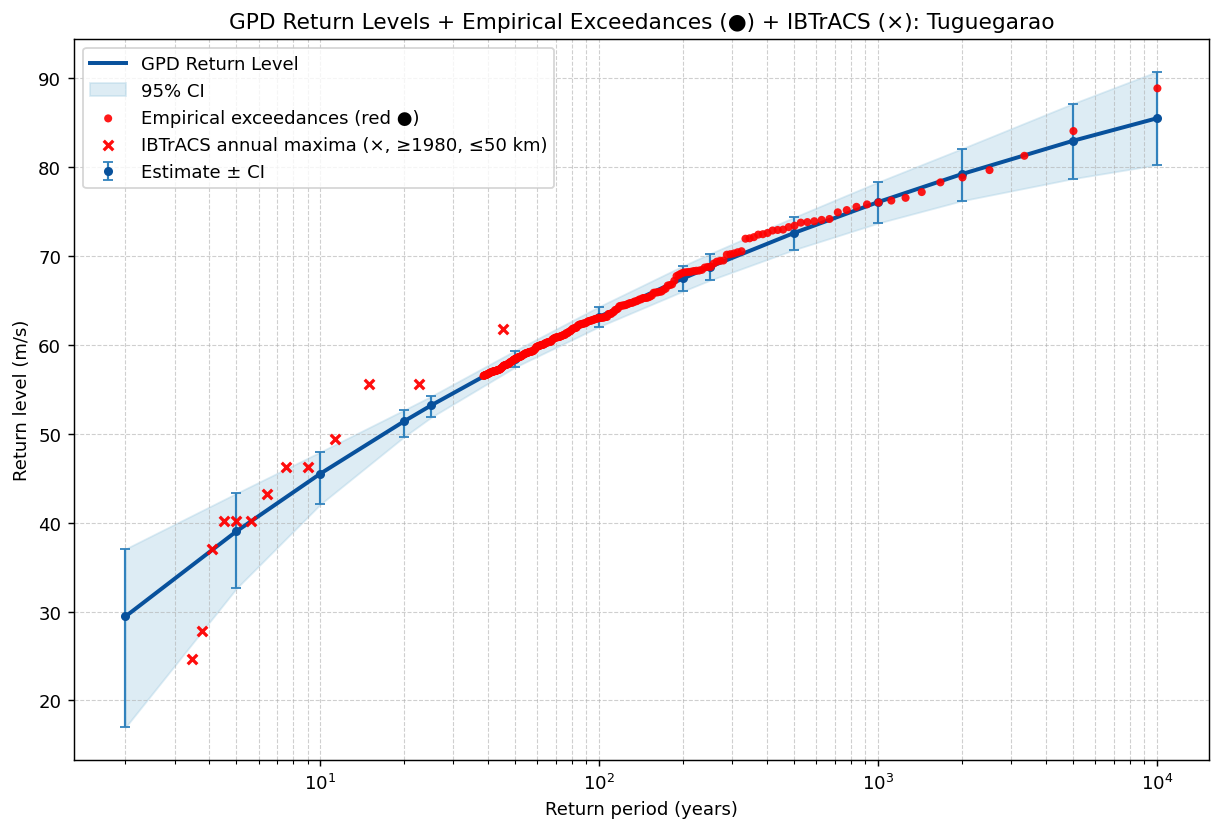

In [18]:
# Example: use your gpdfit outputs (already computed)
# years: array of return periods
# Rp:     return levels
# wl/wu:  lower & upper CI
# mu:     threshold
# rate:   exceedance rate per day
# wspd.wspd: the same data you gave to gpdfit

Rp = w             # from your gpdfit (return levels)
RpLower = wl       # lower CI
RpUpper = wu       # upper CI
loc = l
scale = sc
shp = sh


fig, ax = plot_gpd_with_data_and_ibtracs(
    years=years,
    Rp=Rp,
    RpLower=wl,
    RpUpper=wu,
    data=wspd.wspd,
    mu=mu,
    rate=rate,
    station_name=station_name,
    ylabel="Return level (m/s)",        # set to your units
    use_log_x=True,
    save_path="gpd_RL_empirical_IBTrACS.png",
    ibtracs_csv_path=ibtracs_csv_path,
    station_lat=station_lat, station_lon=station_lon,
    distance=distance,
    year_begin=year_begin,
    ib_input_units="knots",             # IBTrACS winds usually in knots
    ib_output_units="m/s"               # match the units of Rp/wl/wu
)

